# Other visualizations 

### Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

## PLOT 1: PRICE OVER TIME

In [2]:
## Download prices over time
clean_items = pd.read_excel('../output/clean_item_price_time.xlsx')
## Only keep Jewel Awlia file
clean_items_jewel = clean_items.loc[clean_items['kitchen_locality'] == 'Jebel Awlia']
## Only select lentils, pasta, oil, rice and beans
clean_items_jewel =  clean_items_jewel.loc[clean_items['type_of_food'].isin(['lentils', 'pasta', 'oil', 'rice', 'beans'])]

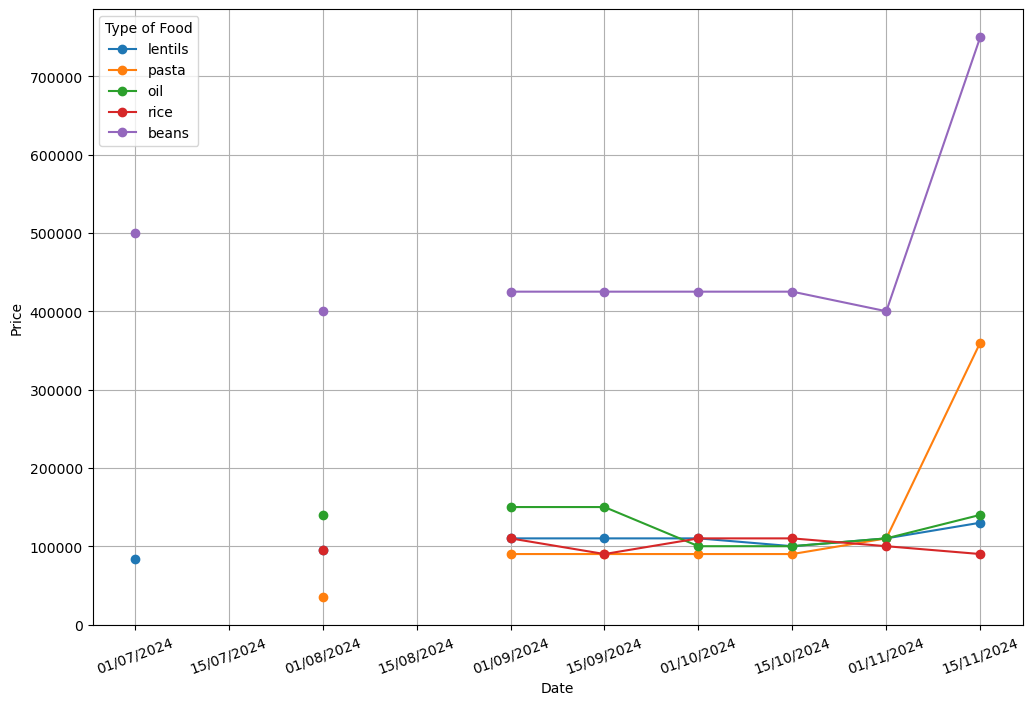

In [3]:
# Line plot
plt.figure(figsize=(12, 8))
food_types = clean_items_jewel['type_of_food'].unique()
for food in food_types:
    subset = clean_items_jewel[clean_items_jewel['type_of_food'] == food]
    plt.plot(subset['date'].to_numpy(), subset['price'].to_numpy(), label=food, marker='o')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation = 20)
plt.legend(title='Type of Food', loc='upper left')
plt.grid(True)
plt.savefig('../visualization/items_price_jewel_awlia_over_time.png')
plt.show()

##  PLOT 2: FUNDING OVER TIME

In [4]:
##Clean date 
clean_items_jewel['date'] = pd.to_datetime(clean_items_jewel['date'], format = '%d/%m/%Y')
## Read dataset 
df_metadata = pd.read_excel('../output/cleaned_metadata.xlsx')

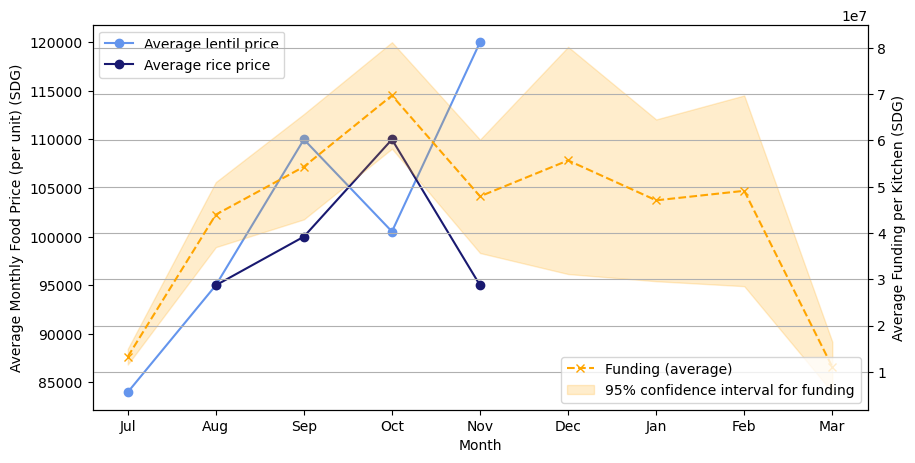

In [5]:
df_merged = df_metadata.merge(clean_items_jewel, on='date', how='outer')
# Compute the average price per date
df_merged['Month'] = df_merged['date'].dt.month
df_merged['Year'] = df_merged['date'].dt.year
# Convert Month numbers to strings
months_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
              7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df_merged['Month_str'] = df_merged['Month'].map(months_map)

lents_price = df_merged.loc[df_merged['type_of_food'] == 'lentils'].groupby(['Month', 'Month_str', 'Year'])['price'].mean().reset_index()
rice_price = df_merged.loc[df_merged['type_of_food'] == 'rice'].groupby(['Month', 'Month_str', 'Year'])['price'].mean().reset_index()
oil_price = df_merged.loc[df_merged['type_of_food'] == 'oil'].groupby(['Month', 'Month_str', 'Year'])['price'].mean().reset_index()
df_merged = df_merged.dropna(subset=['total_cost', 'kitchen_ids'])


# Compute the mean and confidence interval for funding
funding_stats = df_merged.groupby(['Month', 'Month_str', 'Year'])['total_cost'].agg(['mean', 'std', 'count']).reset_index()
funding_stats['ci_upper'] = funding_stats['mean'] + 1.96 * (funding_stats['std'] / np.sqrt(funding_stats['count']))
funding_stats['ci_lower'] = funding_stats['mean'] - 1.96 * (funding_stats['std'] / np.sqrt(funding_stats['count']))
funding_stats = funding_stats.sort_values(['Year', 'Month'])

funding_stats.to_excel('../output/funding_stats.xlsx', index=False)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot average food price on primary y-axis
ax1.plot(lents_price['Month_str'].to_numpy(), lents_price['price'].to_numpy(), label='Average lentil price', color='cornflowerblue', marker='o')
ax1.plot(rice_price['Month_str'].to_numpy(), rice_price['price'].to_numpy(), label='Average rice price', color='midnightblue', marker='o')
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Monthly Food Price (per unit) (SDG)')
ax1.tick_params(axis='y')

# Create secondary y-axis for funding
ax2 = ax1.twinx()
ax2.plot(funding_stats['Month_str'].to_numpy(), funding_stats['mean'].to_numpy(), label='Funding (average)', color='orange', linestyle='--', marker='x')
ax2.fill_between(funding_stats['Month_str'].to_numpy(), funding_stats['ci_lower'].to_numpy(), funding_stats['ci_upper'].to_numpy(), 
                 color='orange', alpha=0.2, label='95% confidence interval for funding')
ax2.set_ylabel('Average Funding per Kitchen (SDG)')
ax2.tick_params(axis='y')

# Formatting
ax1.legend(loc='upper left')
ax2.legend(loc='lower right')
plt.grid(True)

# Save and show
plt.savefig('../visualization/avg_price_funding_CI_over_time.png')
plt.show()


## PLOT3: ACLED NUMBERS

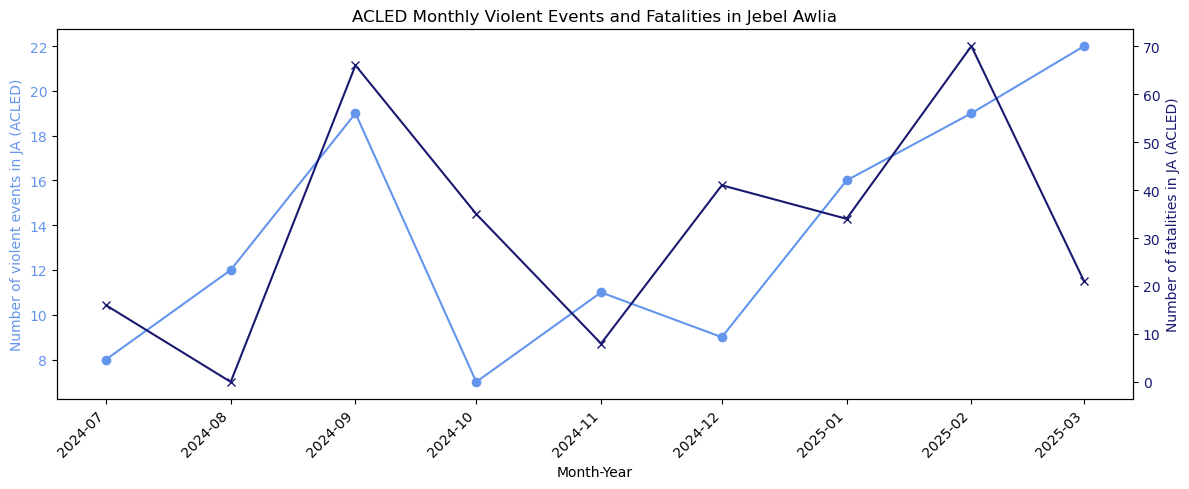

In [6]:
# Read and filter data
acled_data = pd.read_csv('../../1. Data available/ACLED/ACLED_July_Mar_25.csv')
acled_data = acled_data.loc[acled_data['admin2'] == 'Jebel Awlia'][['event_date', 'fatalities']]

# Parse dates and extract Month-Year
acled_data['event_date'] = pd.to_datetime(acled_data['event_date'])
acled_data['Month_Year'] = acled_data['event_date'].dt.to_period('M').dt.to_timestamp()

# Group data
grouped = acled_data.groupby('Month_Year').agg({
    'event_date': 'count',
    'fatalities': 'sum'
}).reset_index()

# Plot
fig, ax1 = plt.subplots(figsize=(12, 5))

# First y-axis: events
ax1.plot(grouped['Month_Year'].to_numpy(), grouped['event_date'].to_numpy(), color='cornflowerblue', marker='o', label='Violent events')
ax1.set_ylabel('Number of violent events in JA (ACLED)', color='cornflowerblue')
ax1.tick_params(axis='y', labelcolor='cornflowerblue')

# Second y-axis: fatalities
ax2 = ax1.twinx()
ax2.plot(grouped['Month_Year'].to_numpy(), grouped['fatalities'].to_numpy(), color='midnightblue', marker='x', label='Fatalities')
ax2.set_ylabel('Number of fatalities in JA (ACLED)', color='midnightblue')
ax2.tick_params(axis='y', labelcolor='midnightblue')

# Improve formatting
ax1.set_title('ACLED Monthly Violent Events and Fatalities in Jebel Awlia')
ax1.set_xlabel('Month-Year')
fig.autofmt_xdate(rotation=45)
fig.tight_layout()

# Save and show
plt.savefig('../visualization/ACLED_information.png', dpi=300)
plt.show()

## PLOT 5: EVERYTHING TOGETHER

In [7]:
grouped_df_date = pd.read_excel('../output/first_draft_cal_per_person_grouped_half_month.xlsx')

# Generate the start date for each month (assuming 'Month' is in 'YYYY-MM' format)
start_dates = pd.to_datetime(grouped_df_date['Year'].astype(str) + '-' + grouped_df_date['Month'].astype(str) + '-01', format='%Y-%m-%d')  # Start of the month

# Half-months column (1 for first half, 2 for second half)
half_months = grouped_df_date['Half']

# Calculate the mid of the month (15th for the second half)
dates = start_dates + pd.to_timedelta((half_months - 1) * 15, unit='D')

grouped_df_date['date'] = pd.to_datetime(grouped_df_date['Year'].astype(str) + '-' + grouped_df_date['Month'].astype(str) + '-01') + pd.to_timedelta((grouped_df_date['Half'] - 1) * 15, unit='D')

# Add year if needed (assuming 2024)
lents_price['date'] = pd.to_datetime(lents_price['Year'].astype(str) + '-' + lents_price['Month'].astype(str).str.zfill(2) + '-01')
rice_price['date'] = pd.to_datetime(rice_price['Year'].astype(str) + '-' + rice_price['Month'].astype(str).str.zfill(2) + '-01')
funding_stats['date'] = pd.to_datetime(funding_stats['Year'].astype(str) +'-' + funding_stats['Month'].astype(str).str.zfill(2) + '-01')

df_attand = pd.read_excel('../output/attendances_completed_imputed.xlsx')
# Generate the start date for each month (assuming 'Month' is in 'YYYY-MM' format)
start_dates = pd.to_datetime(df_attand['Year'].astype(str) + '-' + df_attand['Month'].astype(str) + '-01', format='%Y-%m-%d')  # Start of the month
# Create a 'Half' column: 1 for days 1-15, 2 for days 16-end of month
df_attand['Half'] = df_attand['date'].dt.day.apply(lambda x: 1 if x <= 15 else 2)

# Half-months column (1 for first half, 2 for second half)
half_months = df_attand['Half']

# Calculate the mid of the month (15th for the second half)
dates = start_dates + pd.to_timedelta((half_months - 1) * 15, unit='D')

#Convert Month numbers to strings
months_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
              7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df_attand['Month_str'] = df_attand['Month'].map(months_map)

# Create a Half-Month Column
df_attand['Month_Half'] = start_dates + pd.to_timedelta((half_months - 1) * 15, unit='D')

# Aggregate benef by half-month
benef_time_stats = df_attand.groupby(['Month', 'Month_Half', 'Year'])['est_benef'].agg(['mean', 'std', 'count']).reset_index()
benef_time_stats['ci_upper'] = benef_time_stats['mean'] + 1.96 * (benef_time_stats['std'] / np.sqrt(benef_time_stats['count']))
benef_time_stats['ci_lower'] = benef_time_stats['mean'] - 1.96 * (benef_time_stats['std'] / np.sqrt(benef_time_stats['count']))

benef_time_stats = benef_time_stats.sort_values(['Year', 'Month'])
grouped_df_date = grouped_df_date.sort_values(['Year', 'Month'])

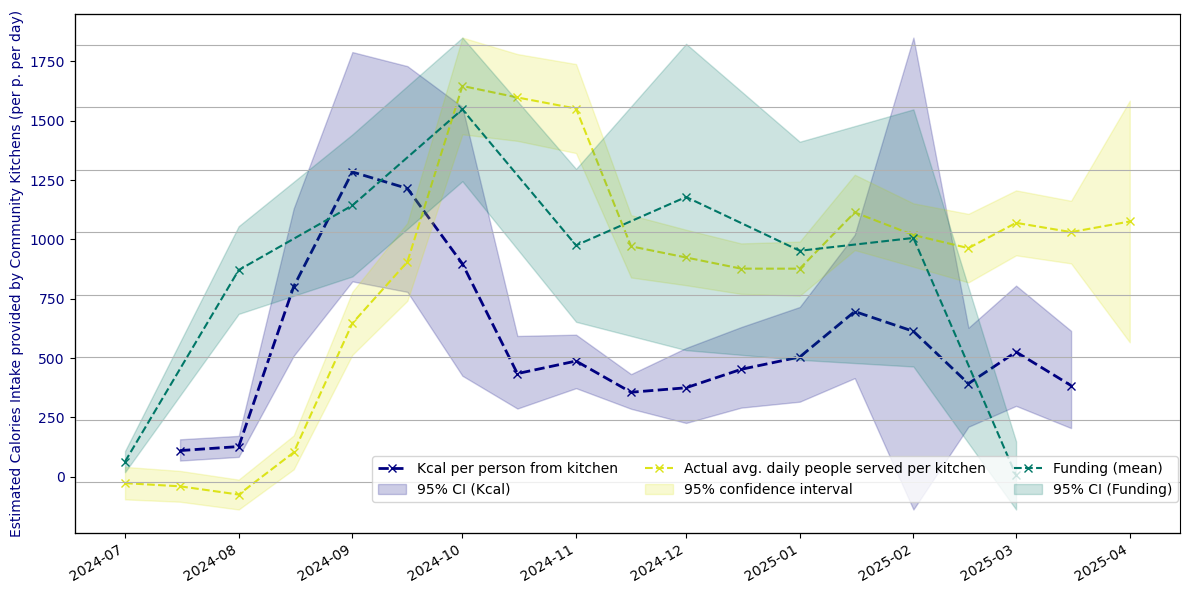

In [8]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# -- Plot kcal intake and CI --
ax1.plot(grouped_df_date['date'].to_numpy(), 
         grouped_df_date[['max_tot_calories_per_p_mean', 'min_tot_calories_per_p_mean']].mean(axis=1).to_numpy(), 
         label='Kcal per person from kitchen', color='navy', linestyle='--', marker='x', linewidth=2)

ax1.fill_between(grouped_df_date['date'], 
                 grouped_df_date['min_tot_calories_per_p_ci_lower'], 
                 grouped_df_date['max_tot_calories_per_p_ci_upper'], 
                 color='navy', alpha=0.2, label='95% CI (Kcal)')

ax1.set_ylabel('Estimated Calories Intake provided by Community Kitchens (per p. per day)', color='navy')
ax1.tick_params(axis='y', labelcolor='navy')

# -- Secondary y-axis for price and funding --
ax2 = ax1.twinx()

# Plot benef and est_benef
ax2.plot(benef_time_stats['Month_Half'].to_numpy(), benef_time_stats['mean'].to_numpy(), 
         label='Actual avg. daily people served per kitchen', color='#dce319ff', linestyle='--', marker='x')
ax2.fill_between(benef_time_stats['Month_Half'].to_numpy(), benef_time_stats['ci_lower'].to_numpy(), benef_time_stats['ci_upper'].to_numpy(), 
                 color='#dce319ff', alpha=0.2, label='95% confidence interval')

ax2.set_ylabel(None)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)
ax2.spines['right'].set_visible(False)

ax3 = ax1.twinx()
ax3.plot(funding_stats['date'].to_numpy(), funding_stats['mean'].to_numpy(), label='Funding (mean)', color='#007767', linestyle='--', marker='x')
ax3.fill_between(funding_stats['date'], funding_stats['ci_lower'], funding_stats['ci_upper'], 
                 color='#007767', alpha=0.2, label='95% CI (Funding)')

ax3.set_ylabel(None)
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)
ax3.spines['right'].set_visible(False)

# -- Final formatting --
fig.autofmt_xdate()
ax1.set_xlabel(None)
# Collect all handles and labels from all axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()

# Combine them with ax3's legend at the bottom
all_handles = handles1 + handles2 + handles3
all_labels = labels1 + labels2 + labels3

# Set the combined legend
fig.legend(all_handles, all_labels, loc='lower center', ncol=3, bbox_to_anchor=(0.65, 0.15))
plt.grid(True)
plt.tight_layout()

plt.savefig('../visualization/merged_plot_kcal_price_funding.png')
plt.show()


## PLOT 6 - SEPARATE THE DIFFERENT CURVES

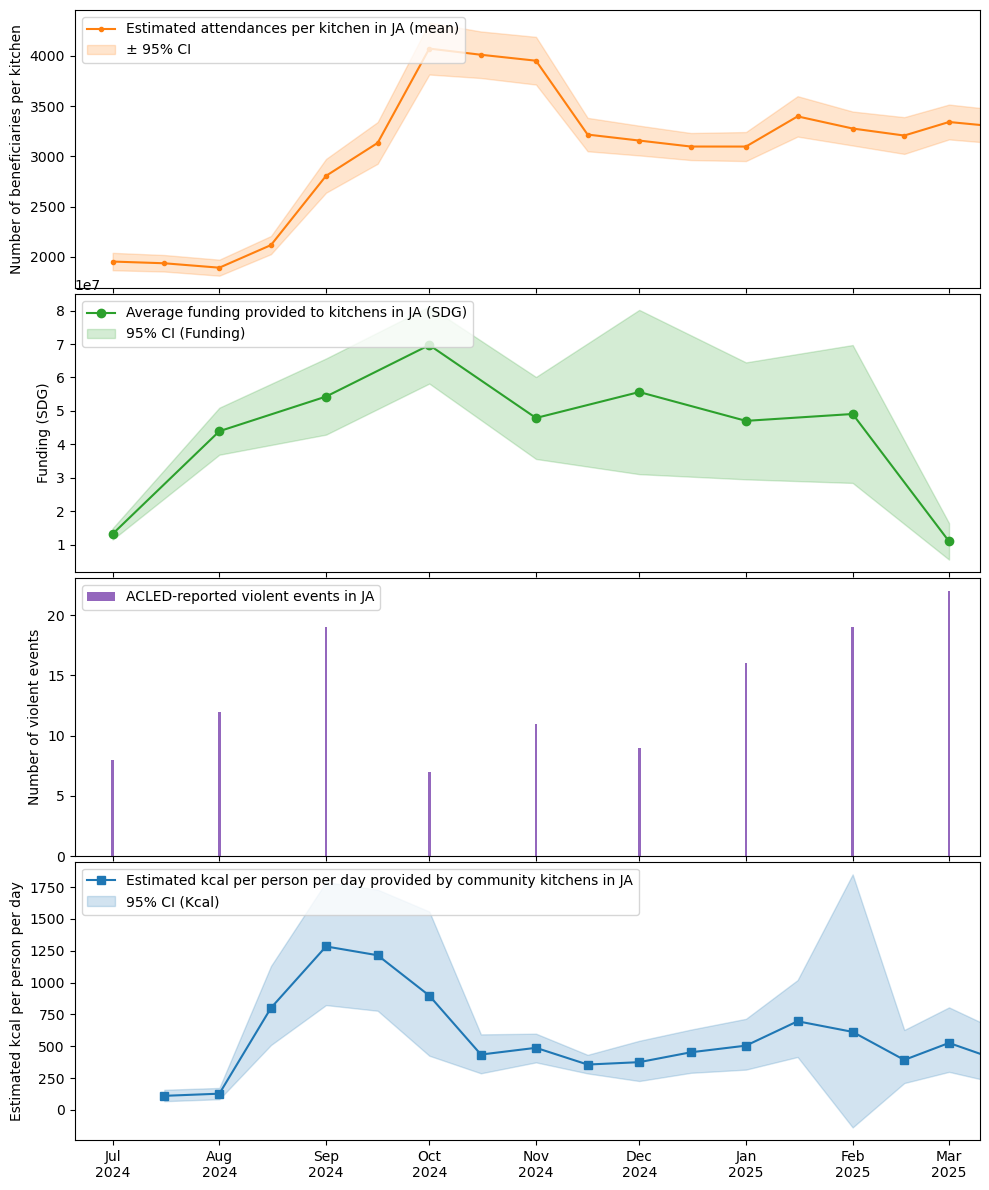

In [9]:
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# --- 1. Attendance per kitchen ---
axs[0].plot(benef_time_stats['Month_Half'].to_numpy(), benef_time_stats['mean'].to_numpy(), color='#ff7f0e',  marker='.',
            label='Estimated attendances per kitchen in JA (mean)')
axs[0].fill_between(benef_time_stats['Month_Half'], benef_time_stats['ci_lower'], benef_time_stats['ci_upper'], 
                    color='#ff7f0e', alpha=0.2, label='± 95% CI')
axs[0].set_ylabel('Number of beneficiaries per kitchen')
axs[0].legend(loc='upper left')
#axs[0].set_title('Trends Over Time')

# --- 2. Funding Over Time ---
axs[1].plot(funding_stats['date'].to_numpy(), funding_stats['mean'].to_numpy(), color='#2ca02c', 
            marker='o', label='Average funding provided to kitchens in JA (SDG)')
axs[1].fill_between(funding_stats['date'], funding_stats['ci_lower'], funding_stats['ci_upper'], 
                 color='#2ca02c', alpha=0.2, label='95% CI (Funding)')
axs[1].set_ylabel('Funding (SDG)')
axs[1].legend(loc='upper left')
#axs[1].set_title('Funding Over Time')

# --- 3. Violent Events Over Time (ACLED) ---
axs[2].bar(grouped['Month_Year'].to_numpy(), grouped['event_date'].to_numpy(),
           color='#9467bd', label ='ACLED-reported violent events in JA')
axs[2].set_ylabel('Number of violent events')
axs[2].legend(loc='upper left')
#axs[2].set_title('Violent Events in Jebel Awlia (ACLED)')


# --- 4. Kcal per person per day ---
axs[3].plot(grouped_df_date['date'].to_numpy(), 
            grouped_df_date[['max_tot_calories_per_p_mean', 'min_tot_calories_per_p_mean']].mean(axis=1).to_numpy(), 
            color='#1f77b4', marker='s',
           label = 'Estimated kcal per person per day provided by community kitchens in JA')
axs[3].set_ylabel('Estimated kcal per person per day')
axs[3].fill_between(grouped_df_date['date'], 
                 grouped_df_date['min_tot_calories_per_p_ci_lower'], 
                 grouped_df_date['max_tot_calories_per_p_ci_upper'], 
                 color='#1f77b4', alpha=0.2, label='95% CI (Kcal)')
axs[3].legend(loc='upper left')
#axs[3].set_title('Estimated Caloric Intake Over Time')


# Format x-axis for better date display
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
axs[3].set_xlim([pd.to_datetime("2024-06-20"), pd.to_datetime("2025-03-10")])
axs[3].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=0)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.02)
plt.savefig('../visualization/four_panel_plot.png', dpi=500)
plt.show()


## Plot 7: COVERAGE JA COMPARED TO THE SUDANESE' pop

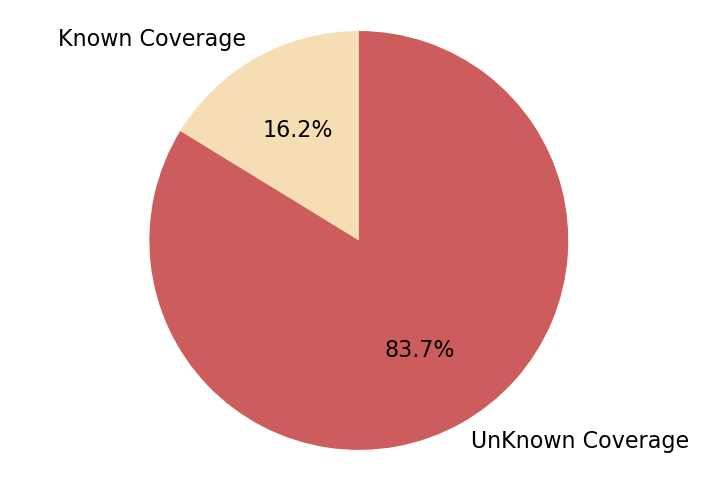

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Data: % of population in JA for each month
population_coverage = [0.15, 0.14, 0.19, 0.17]

# Calculate the average of the population coverage (seen)
average_seen = np.mean(population_coverage)

# The part not seen would be 1 minus the average seen
average_unseen = 1 - average_seen

# Plotting the pie chart
labels = ['Known Coverage', 'UnKnown Coverage']
sizes = [average_seen, average_unseen]
colors = ['#66b3ff', '#ffcc99']

plt.figure(figsize=(9,6), facecolor='none')
plt.pie(sizes, labels=labels, colors=['wheat', 'indianred'], 
        textprops={'fontsize': 16, 'color': 'black'}, autopct='%1.1f%%', startangle=90)
#plt.title('Average Coverage in JA: Seen vs Unseen')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
# Remove background grid (optional)
plt.gca().set_facecolor('none')
plt.savefig('../visualization/coverage.png')
plt.show()

## PLOT 8: CALCULATE and PLOT NUTRIEMENTS

In [14]:
metadata_clean = pd.read_excel('../output/cleaned_metadata.xlsx')
metadata_clean['g_kcal_proteins'] = round((metadata_clean['g_proteins']*4)/metadata_clean['total_calories_available'], 3)
metadata_clean['g_kcal_lipids'] = round((metadata_clean['g_lipids']*9)/metadata_clean['total_calories_available'], 3)

In [15]:
metadata_clean = pd.read_excel('../output/cleaned_metadata.xlsx')
metadata_clean['g_kcal_proteins'] = round((metadata_clean['g_proteins']*4)/metadata_clean['total_calories_available'], 3)
metadata_clean['g_kcal_lipids'] = round((metadata_clean['g_lipids']*9)/metadata_clean['total_calories_available'], 3)

metadata_clean['respect_micro'] = (metadata_clean['g_kcal_proteins'] > 0.1) & (metadata_clean['g_kcal_lipids'] > 0.17)
metadata_clean['respect_micro_prot'] = (metadata_clean['g_kcal_proteins'] > 0.1)
metadata_clean['respect_micro_lipids'] = (metadata_clean['g_kcal_lipids'] > 0.17)
metadata_clean['Month'] = metadata_clean['date'].dt.month
metadata_clean['Year'] = metadata_clean['date'].dt.year

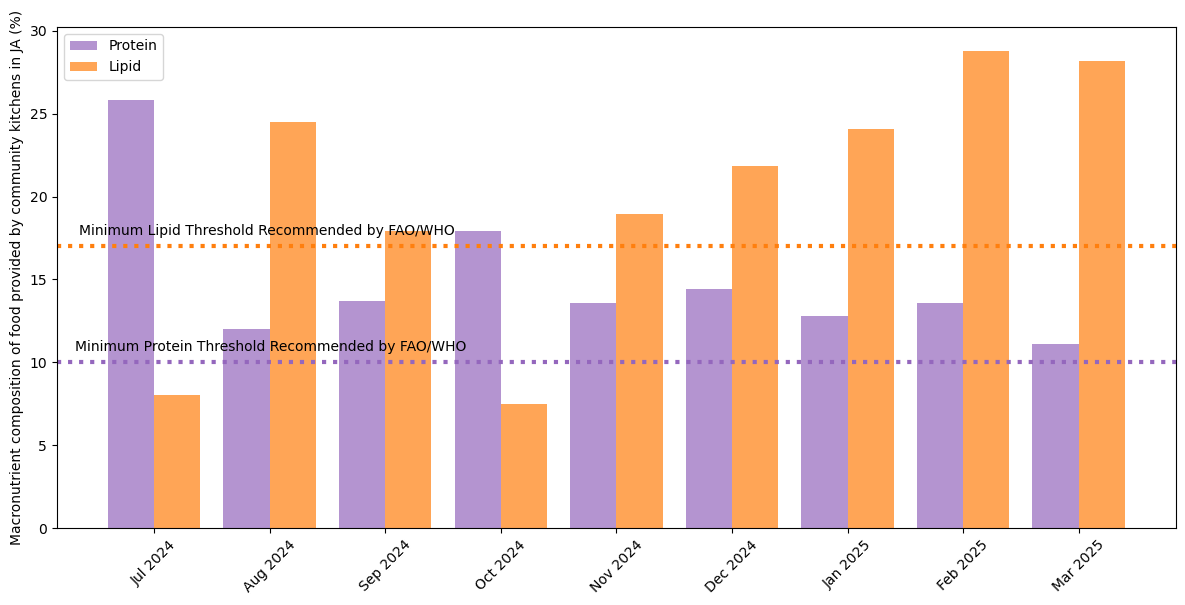

In [19]:
# Group by month and compute proportions
micro_compliance = metadata_clean.groupby(['Year', 'Month']).agg({
    'g_kcal_proteins': 'median',
    'g_kcal_lipids': 'median',
    'nb_type_food': 'mean'
}).reset_index()

# Create a datetime column for plotting (1st of each month)
micro_compliance['date'] = pd.to_datetime(micro_compliance['Year'].astype(str) + '-' + micro_compliance['Month'].astype(str) + '-01')

# Setup
dates = micro_compliance['date']
x = np.arange(len(dates))  # numerical x-axis for positioning
width = 0.4  # width of each bar

# Plot
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, micro_compliance['g_kcal_proteins'] * 100, width=width, label='Protein', color='#9467bd', alpha=0.7)
plt.bar(x + width/2, micro_compliance['g_kcal_lipids'] * 100, width=width, label='Lipid', color='#ff7f0e', alpha=0.7)

# Reference lines
# Plot the line
plt.axhline(10, color='#9467bd', linestyle=':', linewidth=3)
plt.axhline(17, color='#ff7f0e', linestyle=':', linewidth=3)

# Add text next to the lines
plt.text(2.7, 10 + 0.5, 'Minimum Protein Threshold Recommended by FAO/WHO', color='#000000', fontsize=10, va='bottom', ha='right')
plt.text(2.6, 17 + 0.5, 'Minimum Lipid Threshold Recommended by FAO/WHO', color='#000000', fontsize=10, va='bottom', ha='right')

# Formatting
plt.xticks(ticks=x, labels=[d.strftime('%b %Y') for d in dates], rotation=45)
plt.ylabel('Macronutrient composition of food provided by community kitchens in JA (%)')
plt.legend()
plt.tight_layout()
plt.savefig('../visualization/macronutrients.png')
plt.show()

In [17]:
micro_compliance.to_excel('../output/micro_nutriments_over_time.xlsx', index=False)